In [232]:
%matplotlib inline

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    


from graph_tool import load_graph_from_csv, load_graph, GraphView
from graph_tool.topology import label_components, label_largest_component
from collections import Counter, OrderedDict
from tqdm import tqdm


In [295]:
dataset = 'digg'
min_cascade_size = 1000

In [283]:
# g = load_graph_from_csv('data/{}/edges.csv'.format(dataset), csv_options={'delimiter': '\t', 'quotechar': '"'})
g = load_graph('data/{}/graph.gt'.format(dataset))

In [284]:
g.num_vertices(), g.num_edges()

(336225, 1731658)

In [285]:
cs = pd.read_csv('data/{}/cascades.csv'.format(dataset), sep='\t')


In [286]:
c_size = cs[['u', 'c']].groupby('c').count().rename(
    columns={'u': 'size'}
).sort_values(
    by='size',
    ascending=False
)

In [288]:
c_size.head(3)

,size
c,
714,24099
1123,8521
502,8492


In [289]:
def get_subgraph(c_nodes):    
    subg_filt = np.zeros(g.num_vertices())
    subg_filt[c_nodes] = 1    
    
    c = GraphView(g, directed=False, vfilt=subg_filt)
    return c

In [290]:
def cc_stat(c):    
    comp, hist = label_components(c)
    comp_sizes = Counter(comp.a[c_nodes])
    return OrderedDict(
        [('size',  len(c_nodes)), 
         ('top_cc_sizes', [v for _, v in comp_sizes.most_common(5)]),
         ('largest_cc_fraction', hist.max() / hist.sum())]
    )


In [291]:
def cut_stat(subg, g_deg, prefix=''):    
    subg_deg = subg.degree_property_map(deg='out')
    total_deg = sum(g_deg[v] for v in subg.vertices())
    internal_deg = subg.num_edges()  # directed, don't x2
    cut = total_deg - internal_deg
    cut_per_node = cut / subg.num_vertices()
    return OrderedDict([        
            (prefix + 'cut', cut), 
            (prefix + 'cut_per_node', cut_per_node)]
        )

In [ ]:
print('avg_degree', g.num_edges() / g.num_vertices())
lcc = GraphView(g, directed=False, vfilt=label_largest_component(g))
print('avg_degree in lcc', lcc.num_edges() / lcc.num_vertices())

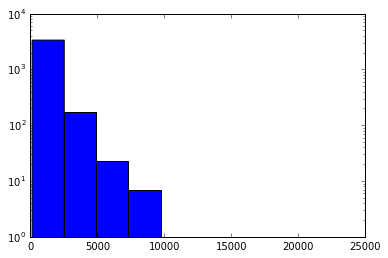

In [293]:
_ = plt.hist(c_size['size'].as_matrix(), log=True) 


In [296]:
c_size_filtered = c_size[c_size['size'] > min_cascade_size]
print('#large cascades: ', c_size_filtered.shape[0])

#large cascades:  759


In [ ]:
stat_list = []
g_deg = g.degree_property_map(deg='out')
for cid in tqdm(c_size_filtered.index):
    c_nodes = cs[cs['c'] == cid]['u'].tolist()
    subg = get_subgraph(c_nodes)
    largest_cc = GraphView(subg, directed=False, vfilt=label_largest_component(subg))
    
    stat = cc_stat(subg)
    stat.update(cut_stat(subg, g_deg))
    stat.update(cut_stat(largest_cc, g_deg, 'lcc_'))
    stat_list.append(stat)

 70%|██████▉   | 528/759 [01:27<00:30,  7.56it/s]

In [273]:
stat_df = pd.DataFrame.from_records(stat_list)

In [281]:
stat_df.to_pickle('result/{}.pkl'.format(dataset))

In [280]:
stat_df.sort_values(by='cut_per_node', ascending=True)

,size,top_cc_sizes,largest_cc_fraction,cut,cut_per_node,lcc_cut,lcc_cut_per_node
260,504,"[3, 2, 2, 2, 1]",0.005952,15900,31.547619,5060,1686.666667
138,621,"[5, 4, 2, 2, 2]",0.008052,21845,35.177134,2736,547.200000
233,524,"[3, 3, 3, 2, 2]",0.005725,19213,36.666031,1757,585.666667
42,882,"[6, 5, 5, 4, 4]",0.006803,32593,36.953515,2656,442.666667
192,561,"[7, 4, 4, 3, 2]",0.012478,22738,40.531194,2456,350.857143
182,570,"[6, 3, 3, 2, 2]",0.010526,25346,44.466667,2453,408.833333
151,599,"[24, 4, 4, 3, 3]",0.040067,27645,46.151920,10311,429.625000
90,706,"[11, 11, 4, 4, 3]",0.015581,33023,46.774788,5913,537.545455
231,528,"[24, 3, 2, 2, 2]",0.045455,24882,47.125000,14056,585.666667
67,775,"[13, 8, 3, 3, 3]",0.016774,37586,48.498065,6708,516.000000
